In [62]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from netCDF4 import Dataset
from scipy.interpolate import RectBivariateSpline

# Part I. Understand noise in Rrs using a small area of the S. Pacific

In [2]:
# get data
files = glob.glob('seawifs_unc_zach/L2_sub_seawifs_gyre/*.nc')
Rrs_wl = np.array([412,443,490,510,555,670])
Rrs = np.array([np.concatenate([Dataset(f).variables['Rrs_%03d'%wl][:].reshape(1,5,5) for f in files]) for wl in Rrs_wl])

In [3]:
Rrs_covs = np.array([np.cov(Rrs[:,i].reshape(len(Rrs_wl),-1)) for i in range(len(files))])
ave_Rrs_cov = np.mean(Rrs_covs,axis=0)

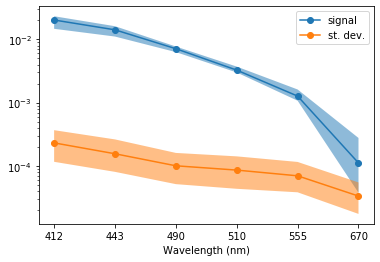

In [4]:
marker='o'
CI = [5,95]
plt.plot(np.median(Rrs,axis=(1,2,3)),marker=marker,label='signal')
plt.fill_between(np.arange(len(Rrs_wl)),*np.percentile(Rrs,CI,axis=(1,2,3)),alpha=0.5)
plt.plot(np.sqrt(np.diag(ave_Rrs_cov)),marker=marker,label='st. dev.')
plt.fill_between(np.arange(len(Rrs_wl)),np.sqrt(np.diag(np.percentile(Rrs_covs,CI[0],axis=0))),np.sqrt(np.diag(np.percentile(Rrs_covs,CI[1],axis=0))),alpha=0.5)
plt.legend(loc=0)
plt.xlabel('Wavelength (nm)')
plt.yscale('log')
plt.xticks(np.arange(len(Rrs_wl)));
plt.gca().set_xticklabels(Rrs_wl);

In [6]:
ave_SNR = np.mean(Rrs,axis=(1,2,3))/np.sqrt(np.diag(ave_Rrs_cov))

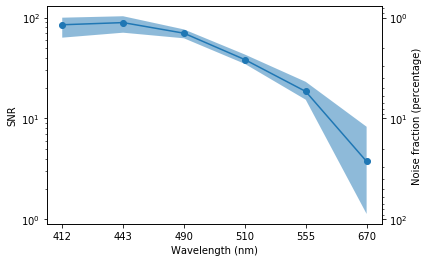

In [7]:
marker='o'
CI = [5,95]
ax = plt.subplot(1,1,1)
plt.plot(ave_SNR,marker=marker)
plt.fill_between(np.arange(len(Rrs_wl)),*np.percentile((Rrs.T/np.sqrt(np.diag(ave_Rrs_cov))).T,CI,axis=(1,2,3)),alpha=0.5)
plt.xlabel('Wavelength (nm)')
plt.yscale('log')
plt.ylabel('SNR')
plt.xticks(np.arange(len(Rrs_wl)));
plt.gca().set_xticklabels(Rrs_wl);
ax2 = plt.twinx()
ax2.set_yscale('log')
ax2.set_ylim(100/np.array(ax.get_ylim()))
ax2.set_ylabel('Noise fraction (percentage)');

# Now look at data from the South Atlantic

In [8]:
filename = 'https://oceandata.sci.gsfc.nasa.gov:443/opendap/SeaWiFS/L3SMI/%04d/%03d/S%04d%03d.L3m_DAY_RRS_Rrs_%03d_9km.nc'
fn = filename%(2000,1,2000,1,443)
nc = Dataset(fn,'r')
nc_lat = nc.variables['lat'][:]
nc_lon = nc.variables['lon'][:]

In [9]:
lat_inds = (nc_lat>-50) & (nc_lat<-30)
lon_inds = (nc_lon>-50) & (nc_lon< 15)

In [10]:
Rrs = Dataset('Old/saved_data_example_SeaWifs_January_2000.nc','r').variables['Rrs'][:,:,lat_inds,lon_inds]
Rrs[Rrs<0] = np.nan

/Users/zerickso/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


490


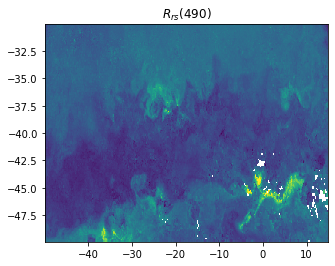

In [147]:
plt.pcolormesh(nc_lon[lon_inds],nc_lat[lat_inds],np.nanmean(Rrs[:,2],axis=(0)),vmax=0.015)
plt.gca().set_aspect(1/0.4)
print(Rrs_wl[2])
plt.title('$R_{rs}(490)$');

In [12]:
def nancov(vals):
    return np.cov(vals[:,np.all(np.isfinite(vals) & (vals>0),axis=0)])

In [13]:
# make dataset of median Rrs for whole area
Rrs_ave_entire = np.array([np.nanmean(Rrs[i],axis=(1,2)) for i in range(Rrs.shape[0])])
# make dataset of covar Rrs for whole area
Rrs_cov_entire = np.array([nancov(Rrs[i]) for i in range(Rrs.shape[0])])

/Users/zerickso/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


One line is the mean per day for a month
Black: Rrs signal
Grey:  Rrs variation (st. dev.)
Red:   noise assuming 5% of signal (spectrally flat)
Green: noise assuming spectral shape from SNR in S. Pac.


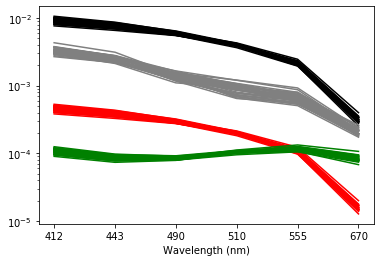

In [154]:
plt.plot(Rrs_ave_entire.T,color='k');
plt.plot(np.array([np.sqrt(np.diag(R)) for R in Rrs_cov_entire]).T,color='0.5')
plt.plot(Rrs_ave_entire.T*0.05,color='r')
plt.plot((Rrs_ave_entire/ave_SNR).T,color='g')
plt.yscale('log')
plt.xlabel('Wavelength (nm)')
plt.xticks(np.arange(len(Rrs_wl)));
plt.gca().set_xticklabels(Rrs_wl);
print('One line is the mean per day for a month')
print('Black: Rrs signal')
print('Grey:  Rrs variation (st. dev.)')
print('Red:   noise assuming 5% of signal (spectrally flat)')
print('Green: noise assuming spectral shape from SNR in S. Pac.')

Define the number of degrees of freedom for each variable as:
$$DoF = \text{diag}\left[S_s(S_s+S_n)^{-1}\right]$$
where $S_s$ is the signal covariance and $S_n$ is the noise (defined from the $R_{rs}$ and the SNR in the S. Pacific).

However, we do not observe the signal - we observe the signal and the noise together. We can add the (co)variances, such that the observed covariance is
$$S_o = S_s+S_n.$$

Then,
$$ DoF = \text{diag}\left[(S_o-S_n)S_o^{-1}\right].$$
Note that off-diagonal elements of $S_n$ are zero by this definition - we could add in these off-diagonal covariances if we modeled $R_{rs}$ based off of $L_t$.

If we additionally ignore covariances in $S_o$, then we simply have
$$ DoF_i = (\sigma_{o,i}^2-\sigma_{n,i}^2)\sigma_{o,i}^{-2} $$
where $\sigma_i$ are the standard deviations for the $i$th element in either the observation or the noise.

Number wavelengths: 6
Total DoF: 3.8 (with covariances)
Total DoF: 5.8 (ignoring covariances)


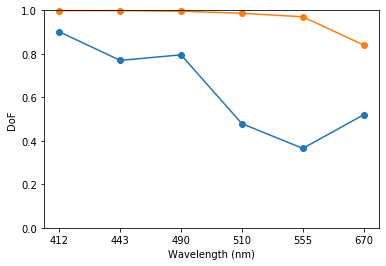

In [57]:
S_n_med = np.diag(np.mean(Rrs_ave_entire/ave_SNR,axis=0))**2
S_o_med = np.mean(Rrs_cov_entire,axis=0)
DoF_med = (S_o_med-S_n_med).dot(np.linalg.inv(S_o_med))
DoF_med2 = (np.diag(np.diag(S_o_med))-S_n_med).dot(np.linalg.inv(np.diag(np.diag(S_o_med))))
plt.plot(np.diag(DoF_med),marker='o',clip_on=False)
plt.plot(np.diag(DoF_med2),marker='o',clip_on=False)
print('Number wavelengths: %d'%len(Rrs_wl))
print('Total DoF: %.1f (with covariances)'%np.trace(DoF_med))
print('Total DoF: %.1f (ignoring covariances)'%np.trace(DoF_med2))
plt.ylim([0,1])
plt.ylabel('DoF')
plt.xlabel('Wavelength (nm)')
plt.xticks(np.arange(len(Rrs_wl)));
plt.gca().set_xticklabels(Rrs_wl);

### Now derive the products from Rrs and calculate the DoF for each

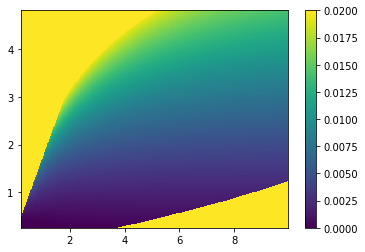

In [148]:
# this is the PIC look-up table
PIC_LUT = np.loadtxt('/Applications/seadas-7.5.3/ocssw/share/common/calcite_table.txt')
xxx = np.unique(PIC_LUT[:,0])
yyy = np.unique(PIC_LUT[:,1])
zzz = PIC_LUT[:,2].reshape(len(np.unique(PIC_LUT[:,0])),len(np.unique(PIC_LUT[:,1]))).T
plt.pcolormesh(xxx,yyy,zzz,vmin=0,vmax=.02)
plt.colorbar();

Create a function for each derived product

In [63]:
f0 = np.loadtxt('f0_edit.txt')
interp_PIC_LUT = RectBivariateSpline(xxx,yyy,zzz.T,kx=1,ky=1)
def get_chlor_a(R):
    CI  = get_CI(R)
    if CI <= 0.15:
        return CI
    if CI >= 0.2:
        return get_ocx(R)
    return CI*(0.2 - CI)/(0.2-0.15) + get_ocx(R)*(CI-0.15)/(0.2-0.15)

def get_CI(R):
    CI =  R[4] - (R[1]+(555.-443.)/(670.-443.)*(R[5]-R[1]))
    return 10**(-0.4909+191.6590*CI)

def get_ocx(R):
    #a = [0.2424, -2.7423, 1.8017, 0.0015, -1.2280] # MODIS; OC3
    a = [0.3272,-2.9940,2.7218,-1.2259,-0.5683] # SeaWiFS; OC4
    Rblue = np.max(R[[1,2,3]])
    return 10**(np.sum([a[i]*np.log10(Rblue/R[4])**i for i in range(len(a))]))

def get_pic(R):
    return interp_PIC_LUT(get_nLw(443,R[1]),get_nLw(555,R[4]))[0][0]/1.628

def get_poc(R):
    return 203.2*(R[1]/R[4])**-1.034

def get_Kd_490(R):
    # a = [-0.8813, -2.0584, 2.5878, -3.4885, -1.5061] # MODIS
    a = [-0.8515, -1.8263, 1.8714, -2.4414, -1.0690] # SeaWiFS
    return 0.0166 + 10**(a[0] + np.sum([a[i]*np.log10(R[2]/R[4])**i for i in range(1,len(a))]))
    
#def get_nflh(R):
#    return (get_nLw(678,R[6]) - (70*get_nLw(667,R[5]))/81)*10

def get_nLw(wl,R):
    return R*np.interp(wl,f0[:,0],f0[:,1])

In [116]:
# make derived function dataset
funcs = (get_chlor_a,get_pic,get_poc,get_Kd_490)
func_names = ['chlor_a','pic','poc','Kd_490']
products = np.array([[[[funcs[j](Rrs[i,:,k,l]) 
                        for l in range(Rrs.shape[3])] for k in range(Rrs.shape[2])] 
                        for j in range(len(funcs))]   for i in range(Rrs.shape[0])])
products[:,1,:,:][products[:,1,:,:]>1] = np.nan

In [67]:
# make dataset of median products for whole area
products_ave_entire = np.array([np.nanmean(products[i],axis=(1,2)) for i in range(products.shape[0])])
# make dataset of covar Rrs for whole area
products_cov_entire = np.array([nancov(products[i]) for i in range(products.shape[0])])

/Users/zerickso/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


The noise for the product, $S_{np}$, is simply
$$S_{np} = KS_nK^T$$
where
$$K = \frac{\partial\mathcal{f}}{\partial R_{rs}}$$
for a derived function $\mathcal{f}$.

In [129]:
dRrs = np.array([.01*Rrs_ave_entire[i] for i in range(Rrs_ave_entire.shape[0])])
Kinv_entire = np.array([[[(func(Rrs_ave_entire[i]+dRrs[i,j])-func(Rrs_ave_entire[i]))/np.sum(dRrs[i,j]) 
           for func in funcs] for j in range(len(Rrs_wl))] for i in range(Rrs_ave_entire.shape[0])]) 
noise_cov_entire = np.array([Kinv_entire[i].T.dot(np.diag(Rrs_ave_entire[i]/ave_SNR)**2).dot(Kinv_entire[i]) for i in range(Kinv_entire.shape[0])])


In [152]:
print('Products:',func_names)
print('Mean values:   ',np.mean(products_ave_entire,axis=0))
print('St. devs.:     ',np.sqrt(np.diag(np.mean(products_cov_entire,axis=0))))
print('Noise from Rrs:',np.sqrt(np.diag(np.mean(noise_cov_entire,axis=0))))

Products: ['chlor_a', 'pic', 'poc', 'Kd_490']
Mean values:    [2.34947255e-01 1.50159618e-04 6.36719674e+01 4.81985396e-02]
St. devs.:      [2.04694152e-01 2.00069914e-04 3.31034391e+01 2.07928360e-02]
Noise from Rrs: [4.88211664e-03 7.45830650e-05 4.50446047e+00 3.96987387e-03]


Number products: 4
Total DoF: 3.6 (with covariances)
Total DoF: 3.8 (ignoring signal covariances)
Total DoF: 2.8 (ignoring noise covariances)


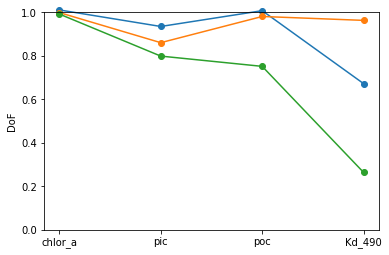

In [141]:
S_n_med = np.mean(noise_cov_entire,axis=0)
S_o_med = np.mean(products_cov_entire,axis=0)
DoF_med = (S_o_med-S_n_med).dot(np.linalg.inv(S_o_med))
DoF_med2 = (np.diag(np.diag(S_o_med))-S_n_med).dot(np.linalg.inv(np.diag(np.diag(S_o_med))))
DoF_med3 = (S_o_med-np.diag(np.diag(S_n_med))).dot(np.linalg.inv(S_o_med))
plt.plot(np.diag(DoF_med),marker='o',clip_on=False)
plt.plot(np.diag(DoF_med2),marker='o',clip_on=False)
plt.plot(np.diag(DoF_med3),marker='o',clip_on=False)
print('Number products: %d'%len(funcs))
print('Total DoF: %.1f (with covariances)'%np.trace(DoF_med))
print('Total DoF: %.1f (ignoring signal covariances)'%np.trace(DoF_med2))
print('Total DoF: %.1f (ignoring noise covariances)'%np.trace(DoF_med3))
plt.ylim([0,1])
plt.ylabel('DoF')
plt.xticks(np.arange(len(funcs)));
plt.gca().set_xticklabels(func_names);